In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn_no_DO(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv1D(kernel_size=25, filters=8, strides=1, padding='valid', 
                  activation='relu', input_shape=input_shape))  
    model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=8*(2**(i+1)), strides=1, padding='valid', 
                          activation='relu'))  
        model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense( 1024/(2**i), activation='relu' ))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

In [12]:
for i in range(1, 6):
    for j in range(1, 3):
        model = build_cnn_no_DO(conv_num=i, fcn_num=j)
        model.summary()
        del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 31952)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              32719872  
_________________________________________________________________
dense_13 (Dense)             (None, 16)                16400     
Total params: 32,736,480
Trainable params: 32,736,480
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 3970, 16)          3216      
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 993, 16)           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 969, 32)           12832     
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 243, 32)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 219, 64)           51264     
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.9868 - acc: 0.3856
Epoch 00001: val_loss improved from inf to 1.54374, saving model to model/checkpoint/1D_CNN_no_DO_1_conv_1_fcn_checkpoint/01-1.5437.hdf5
36805/36805 [==============================] - 15s 406us/sample - loss: 1.9855 - acc: 0.3858 - val_loss: 1.5437 - val_acc: 0.5341
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.2397 - acc: 0.6229
Epoch 00002: val_loss improved from 1.54374 to 1.28969, saving model to model/checkpoint/1D_CNN_no_DO_1_conv_1_fcn_checkpoint/02-1.2897.hdf5
36805/36805 [==============================] - 14s 390us/sample - loss: 1.2394 - acc: 0.6230 - val_loss: 1.2897 - val_acc: 0.6061
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.8847 - acc: 0.7412
Epoch 00003: val_loss improved from 1.28969 to 1.17044, saving model to model/checkpoint/1D_CNN_no_DO_1_conv_1_fcn_checkpoint

Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9983
Epoch 00029: val_loss did not improve from 1.06723
36805/36805 [==============================] - 14s 381us/sample - loss: 0.0147 - acc: 0.9983 - val_loss: 1.5425 - val_acc: 0.7102
Epoch 30/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9947
Epoch 00030: val_loss did not improve from 1.06723
36805/36805 [==============================] - 14s 381us/sample - loss: 0.0256 - acc: 0.9947 - val_loss: 1.6624 - val_acc: 0.6900
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9970
Epoch 00031: val_loss did not improve from 1.06723
36805/36805 [==============================] - 14s 379us/sample - loss: 0.0197 - acc: 0.9970 - val_loss: 1.6211 - val_acc: 0.7065
Epoch 32/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9976
Epoch 00032: val_loss did not improve from 1.06723
36805/36805 [=====

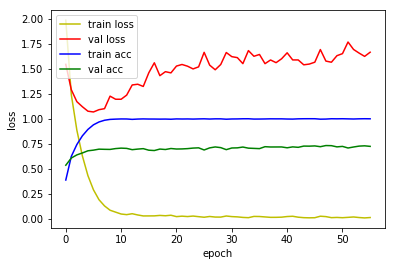

4815/4815 [==============================] - 1s 185us/sample - loss: 1.2104 - acc: 0.6420
Loss: 1.2103684863321258 Accuracy: 0.6419522

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.9676 - acc: 0.3736
Epoch 00001: val_loss improved from inf to 1.45086, saving model to model/checkpoint/1D_CNN_no_DO_1_conv_2_fcn_checkpoint/01-1.4509.hdf5
36805/36805 [==============================] - 16s 433us/sample - loss: 1.9666 - acc: 0.3738 - val_loss: 1.4509 - val_acc: 0.5376
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.1354 - acc: 0.6457
Epoch 00002: val_loss improved from 1.45086 to 1.15513, saving model to model/checkpoint/1D_CNN_no_DO_1_conv_2_fcn_checkpoint/02-1.1551.hdf5
36805/36805 [==============================] - 15s 395us/sample - loss: 1.1354 - acc: 0.6457 - val_loss: 1.1551 - val_acc: 0.6394
Epoch 3/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.7242 - a

Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9921
Epoch 00029: val_loss did not improve from 0.96862
36805/36805 [==============================] - 13s 360us/sample - loss: 0.0301 - acc: 0.9920 - val_loss: 1.4734 - val_acc: 0.7438
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9963
Epoch 00030: val_loss did not improve from 0.96862
36805/36805 [==============================] - 14s 384us/sample - loss: 0.0174 - acc: 0.9963 - val_loss: 1.4497 - val_acc: 0.7522
Epoch 31/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9984
Epoch 00031: val_loss did not improve from 0.96862
36805/36805 [==============================] - 13s 363us/sample - loss: 0.0101 - acc: 0.9984 - val_loss: 1.3734 - val_acc: 0.7626
Epoch 32/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9967
Epoch 00032: val_loss did not improve from 0.96862
36805/36805 [=====

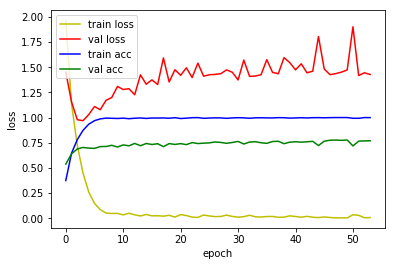

4815/4815 [==============================] - 1s 168us/sample - loss: 1.1448 - acc: 0.6565
Loss: 1.1447647873362525 Accuracy: 0.65649015

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.8760 - acc: 0.4067
Epoch 00001: val_loss improved from inf to 1.35296, saving model to model/checkpoint/1D_CNN_no_DO_2_conv_1_fcn_checkpoint/01-1.3530.hdf5
36805/36805 [==============================] - 13s 364us/sample - loss: 1.8756 - acc: 0.4069 - val_loss: 1.3530 - val_acc: 0.5840
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1657 - acc: 0.6377
Epoch 00002: val_loss improved from 1.35296 to 1.09615, saving model to model/checkpoint/1D_CNN_no_DO_2_conv_1_fcn_checkpoint/02-1.0962.hdf5
36805/36805 [==============================] - 12s 326us/sample - loss: 1.1654 - acc: 0.6378 - val_loss: 1.0962 - val_acc: 0.6681
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.8795 - 

Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0052 - acc: 0.9997
Epoch 00028: val_loss did not improve from 0.75771
36805/36805 [==============================] - 11s 308us/sample - loss: 0.0052 - acc: 0.9997 - val_loss: 1.1001 - val_acc: 0.7945
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9852
Epoch 00029: val_loss did not improve from 0.75771
36805/36805 [==============================] - 11s 305us/sample - loss: 0.0575 - acc: 0.9852 - val_loss: 1.0606 - val_acc: 0.7741
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9955
Epoch 00030: val_loss did not improve from 0.75771
36805/36805 [==============================] - 11s 303us/sample - loss: 0.0231 - acc: 0.9955 - val_loss: 1.0559 - val_acc: 0.7925
Epoch 31/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9991
Epoch 00031: val_loss did not improve from 0.75771
36805/36805 [=====

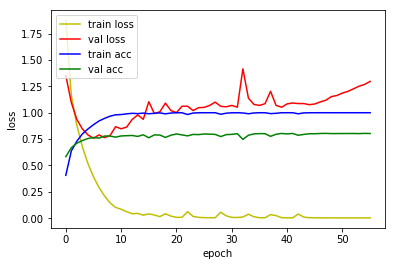

4815/4815 [==============================] - 1s 217us/sample - loss: 0.9070 - acc: 0.7275
Loss: 0.9069706133716698 Accuracy: 0.7275182

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.8839 - acc: 0.3986
Epoch 00001: val_loss improved from inf to 1.38454, saving model to model/checkpoint/1D_CNN_no_DO_2_conv_2_fcn_checkpoint/01-1.3845.hdf5
36805/36805 [==============================] - 14s 383us/sample - loss: 1.8829 - acc: 0.3989 - val_loss: 1.3845 - val_acc: 0.5644
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1302 - acc: 0.6435
Epoch 00002: val_loss improved from 1.38454 to 1.03512, saving model to model/checkpoint/1D_CNN_no_DO_2_conv_2_fcn_checkpoint/02-1.0351.hdf5
36805/36805 [==============================] - 12s 332us/sample - loss: 1.1296 - acc: 0.6436 - val_loss: 1.0351 - val_acc: 0.6716
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.8083 - a

36736/36805 [============================>.] - ETA: 0s - loss: 0.0052 - acc: 0.9991
Epoch 00028: val_loss did not improve from 0.68192
36805/36805 [==============================] - 11s 312us/sample - loss: 0.0052 - acc: 0.9991 - val_loss: 1.0176 - val_acc: 0.8185
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9889
Epoch 00029: val_loss did not improve from 0.68192
36805/36805 [==============================] - 12s 314us/sample - loss: 0.0393 - acc: 0.9889 - val_loss: 1.0969 - val_acc: 0.8046
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9983
Epoch 00030: val_loss did not improve from 0.68192
36805/36805 [==============================] - 11s 311us/sample - loss: 0.0092 - acc: 0.9983 - val_loss: 0.9998 - val_acc: 0.8246
Epoch 31/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9962
Epoch 00031: val_loss did not improve from 0.68192
36805/36805 [==================

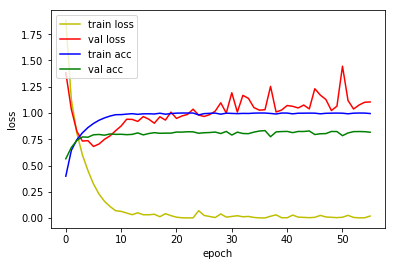

4815/4815 [==============================] - 1s 208us/sample - loss: 0.8330 - acc: 0.7570
Loss: 0.8329513696619035 Accuracy: 0.7570093

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.8728 - acc: 0.3997
Epoch 00001: val_loss improved from inf to 1.35792, saving model to model/checkpoint/1D_CNN_no_DO_3_conv_1_fcn_checkpoint/01-1.3579.hdf5
36805/36805 [==============================] - 14s 385us/sample - loss: 1.8720 - acc: 0.3998 - val_loss: 1.3579 - val_acc: 0.5784
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1960 - acc: 0.6262
Epoch 00002: val_loss improved from 1.35792 to 1.01003, saving model to model/checkpoint/1D_CNN_no_DO_3_conv_1_fcn_checkpoint/02-1.0100.hdf5
36805/36805 [==============================] - 12s 320us/sample - loss: 1.1952 - acc: 0.6264 - val_loss: 1.0100 - val_acc: 0.6897
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.9016 - a

Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0187 - acc: 0.9963
Epoch 00027: val_loss did not improve from 0.44726
36805/36805 [==============================] - 11s 307us/sample - loss: 0.0187 - acc: 0.9963 - val_loss: 0.6668 - val_acc: 0.8654
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9907
Epoch 00028: val_loss did not improve from 0.44726
36805/36805 [==============================] - 11s 308us/sample - loss: 0.0323 - acc: 0.9907 - val_loss: 0.5710 - val_acc: 0.8791
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9980
Epoch 00029: val_loss did not improve from 0.44726
36805/36805 [==============================] - 11s 306us/sample - loss: 0.0116 - acc: 0.9980 - val_loss: 0.5990 - val_acc: 0.8824
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9951
Epoch 00030: val_loss did not improve from 0.44726
36805/36805 [=====

Epoch 57/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9999
Epoch 00057: val_loss did not improve from 0.44726
36805/36805 [==============================] - 11s 290us/sample - loss: 0.0016 - acc: 0.9999 - val_loss: 0.6193 - val_acc: 0.8933
Epoch 58/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9950
Epoch 00058: val_loss did not improve from 0.44726
36805/36805 [==============================] - 11s 290us/sample - loss: 0.0174 - acc: 0.9950 - val_loss: 0.6675 - val_acc: 0.8707
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9977
Epoch 00059: val_loss did not improve from 0.44726
36805/36805 [==============================] - 11s 290us/sample - loss: 0.0093 - acc: 0.9977 - val_loss: 0.6515 - val_acc: 0.8810
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9989
Epoch 00060: val_loss did not improve from 0.44726
36805/36805 [=====

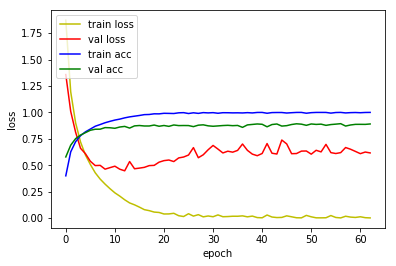

4815/4815 [==============================] - 1s 221us/sample - loss: 0.5923 - acc: 0.8289
Loss: 0.5922604890132124 Accuracy: 0.8288681

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.8329 - acc: 0.4042
Epoch 00001: val_loss improved from inf to 1.28096, saving model to model/checkpoint/1D_CNN_no_DO_3_conv_2_fcn_checkpoint/01-1.2810.hdf5
36805/36805 [==============================] - 15s 413us/sample - loss: 1.8321 - acc: 0.4044 - val_loss: 1.2810 - val_acc: 0.5921
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.1165 - acc: 0.6389
Epoch 00002: val_loss improved from 1.28096 to 0.94586, saving model to model/checkpoint/1D_CNN_no_DO_3_conv_2_fcn_checkpoint/02-0.9459.hdf5
36805/36805 [==============================] - 12s 333us/sample - loss: 1.1171 - acc: 0.6387 - val_loss: 0.9459 - val_acc: 0.6879
Epoch 3/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.8409 - a

36736/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9899
Epoch 00026: val_loss did not improve from 0.43500
36805/36805 [==============================] - 11s 297us/sample - loss: 0.0367 - acc: 0.9899 - val_loss: 0.5738 - val_acc: 0.8775
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9934
Epoch 00027: val_loss did not improve from 0.43500
36805/36805 [==============================] - 11s 300us/sample - loss: 0.0276 - acc: 0.9934 - val_loss: 0.5991 - val_acc: 0.8775
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9950
Epoch 00028: val_loss did not improve from 0.43500
36805/36805 [==============================] - 11s 301us/sample - loss: 0.0196 - acc: 0.9950 - val_loss: 0.6064 - val_acc: 0.8817
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9918
Epoch 00029: val_loss did not improve from 0.43500
36805/36805 [==================

Epoch 56/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9970
Epoch 00056: val_loss did not improve from 0.43500
36805/36805 [==============================] - 11s 302us/sample - loss: 0.0110 - acc: 0.9970 - val_loss: 0.7930 - val_acc: 0.8719
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9968
Epoch 00057: val_loss did not improve from 0.43500
36805/36805 [==============================] - 11s 299us/sample - loss: 0.0125 - acc: 0.9968 - val_loss: 0.7025 - val_acc: 0.8793
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9982
Epoch 00058: val_loss did not improve from 0.43500
36805/36805 [==============================] - 11s 300us/sample - loss: 0.0093 - acc: 0.9982 - val_loss: 0.6542 - val_acc: 0.8868
Epoch 59/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9991
Epoch 00059: val_loss did not improve from 0.43500
36805/36805 [=====

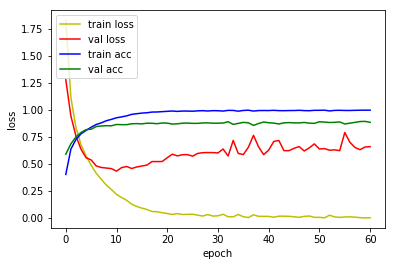

4815/4815 [==============================] - 1s 213us/sample - loss: 0.5952 - acc: 0.8272
Loss: 0.5951518520759274 Accuracy: 0.8272067

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.7900 - acc: 0.4325
Epoch 00001: val_loss improved from inf to 1.19318, saving model to model/checkpoint/1D_CNN_no_DO_4_conv_1_fcn_checkpoint/01-1.1932.hdf5
36805/36805 [==============================] - 14s 383us/sample - loss: 1.7900 - acc: 0.4325 - val_loss: 1.1932 - val_acc: 0.6352
Epoch 2/200
36608/36805 [============================>.] - ETA: 0s - loss: 1.0129 - acc: 0.6846
Epoch 00002: val_loss improved from 1.19318 to 0.81719, saving model to model/checkpoint/1D_CNN_no_DO_4_conv_1_fcn_checkpoint/02-0.8172.hdf5
36805/36805 [==============================] - 10s 270us/sample - loss: 1.0123 - acc: 0.6848 - val_loss: 0.8172 - val_acc: 0.7452
Epoch 3/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.7903 - a

Epoch 26/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0531 - acc: 0.9845
Epoch 00026: val_loss did not improve from 0.39966
36805/36805 [==============================] - 10s 269us/sample - loss: 0.0531 - acc: 0.9846 - val_loss: 0.5035 - val_acc: 0.8994
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0551 - acc: 0.9839
Epoch 00027: val_loss did not improve from 0.39966
36805/36805 [==============================] - 10s 270us/sample - loss: 0.0551 - acc: 0.9839 - val_loss: 0.5204 - val_acc: 0.8919
Epoch 28/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0593 - acc: 0.9825
Epoch 00028: val_loss did not improve from 0.39966
36805/36805 [==============================] - 10s 268us/sample - loss: 0.0594 - acc: 0.9824 - val_loss: 0.4831 - val_acc: 0.8961
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0452 - acc: 0.9873
Epoch 00029: val_loss did not improve from 0.39966
36805/36805 [=====

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9930
Epoch 00056: val_loss did not improve from 0.39966
36805/36805 [==============================] - 10s 267us/sample - loss: 0.0261 - acc: 0.9930 - val_loss: 0.5694 - val_acc: 0.9036
Epoch 57/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9956
Epoch 00057: val_loss did not improve from 0.39966
36805/36805 [==============================] - 10s 266us/sample - loss: 0.0159 - acc: 0.9955 - val_loss: 0.5635 - val_acc: 0.9031
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9958
Epoch 00058: val_loss did not improve from 0.39966
36805/36805 [==============================] - 10s 266us/sample - loss: 0.0177 - acc: 0.9958 - val_loss: 0.5481 - val_acc: 0.9094
Epoch 59/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9977
Epoch 00059: val_loss did not improve from 0.39966
36805/36805 [=====

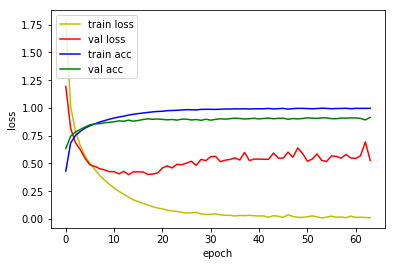

4815/4815 [==============================] - 1s 239us/sample - loss: 0.5281 - acc: 0.8507
Loss: 0.5280591603503916 Accuracy: 0.850675

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.8168 - acc: 0.4095
Epoch 00001: val_loss improved from inf to 1.17719, saving model to model/checkpoint/1D_CNN_no_DO_4_conv_2_fcn_checkpoint/01-1.1772.hdf5
36805/36805 [==============================] - 15s 404us/sample - loss: 1.8159 - acc: 0.4097 - val_loss: 1.1772 - val_acc: 0.6240
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.0175 - acc: 0.6733
Epoch 00002: val_loss improved from 1.17719 to 0.82871, saving model to model/checkpoint/1D_CNN_no_DO_4_conv_2_fcn_checkpoint/02-0.8287.hdf5
36805/36805 [==============================] - 11s 306us/sample - loss: 1.0171 - acc: 0.6734 - val_loss: 0.8287 - val_acc: 0.7310
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.7706 - ac

Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9904
Epoch 00027: val_loss did not improve from 0.40060
36805/36805 [==============================] - 11s 296us/sample - loss: 0.0350 - acc: 0.9903 - val_loss: 0.6321 - val_acc: 0.8798
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9881
Epoch 00028: val_loss did not improve from 0.40060
36805/36805 [==============================] - 11s 295us/sample - loss: 0.0421 - acc: 0.9881 - val_loss: 0.6040 - val_acc: 0.8852
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9898
Epoch 00029: val_loss did not improve from 0.40060
36805/36805 [==============================] - 11s 298us/sample - loss: 0.0340 - acc: 0.9898 - val_loss: 0.5447 - val_acc: 0.8982
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9926
Epoch 00030: val_loss did not improve from 0.40060
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9976
Epoch 00057: val_loss did not improve from 0.40060
36805/36805 [==============================] - 11s 288us/sample - loss: 0.0091 - acc: 0.9976 - val_loss: 0.6457 - val_acc: 0.9001
Epoch 58/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0168 - acc: 0.9949
Epoch 00058: val_loss did not improve from 0.40060
36805/36805 [==============================] - 11s 291us/sample - loss: 0.0169 - acc: 0.9948 - val_loss: 0.6042 - val_acc: 0.9036
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0073 - acc: 0.9985
Epoch 00059: val_loss did not improve from 0.40060
36805/36805 [==============================] - 11s 289us/sample - loss: 0.0073 - acc: 0.9985 - val_loss: 0.5905 - val_acc: 0.9101
Epoch 60/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9965
Epoch 00060: val_loss did not improve from 0.40060
36805/36805 [=====

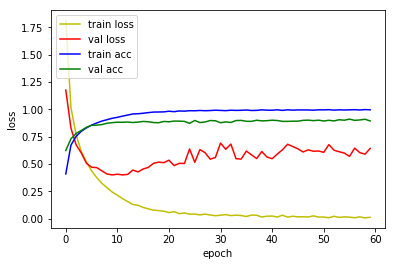

4815/4815 [==============================] - 1s 248us/sample - loss: 0.5119 - acc: 0.8511
Loss: 0.5119455940626864 Accuracy: 0.8510904

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.8809 - acc: 0.3845
Epoch 00001: val_loss improved from inf to 1.25262, saving model to model/checkpoint/1D_CNN_no_DO_5_conv_1_fcn_checkpoint/01-1.2526.hdf5
36805/36805 [==============================] - 15s 417us/sample - loss: 1.8809 - acc: 0.3845 - val_loss: 1.2526 - val_acc: 0.5826
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.0793 - acc: 0.6561
Epoch 00002: val_loss improved from 1.25262 to 0.88788, saving model to model/checkpoint/1D_CNN_no_DO_5_conv_1_fcn_checkpoint/02-0.8879.hdf5
36805/36805 [==============================] - 10s 277us/sample - loss: 1.0793 - acc: 0.6561 - val_loss: 0.8879 - val_acc: 0.7130
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.8231 - a

Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0764 - acc: 0.9745
Epoch 00025: val_loss did not improve from 0.30064
36805/36805 [==============================] - 10s 277us/sample - loss: 0.0765 - acc: 0.9745 - val_loss: 0.3775 - val_acc: 0.9131
Epoch 26/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.0765 - acc: 0.9742
Epoch 00026: val_loss did not improve from 0.30064
36805/36805 [==============================] - 10s 276us/sample - loss: 0.0766 - acc: 0.9742 - val_loss: 0.3533 - val_acc: 0.9168
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0661 - acc: 0.9780
Epoch 00027: val_loss did not improve from 0.30064
36805/36805 [==============================] - 10s 278us/sample - loss: 0.0661 - acc: 0.9780 - val_loss: 0.3730 - val_acc: 0.9192
Epoch 28/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0602 - acc: 0.9798
Epoch 00028: val_loss did not improve from 0.30064
36805/36805 [=====

Epoch 55/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9927
Epoch 00055: val_loss did not improve from 0.30064
36805/36805 [==============================] - 10s 276us/sample - loss: 0.0240 - acc: 0.9927 - val_loss: 0.4822 - val_acc: 0.9262
Epoch 56/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9915
Epoch 00056: val_loss did not improve from 0.30064
36805/36805 [==============================] - 10s 274us/sample - loss: 0.0277 - acc: 0.9914 - val_loss: 0.4683 - val_acc: 0.9245
Epoch 57/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9937
Epoch 00057: val_loss did not improve from 0.30064
36805/36805 [==============================] - 10s 275us/sample - loss: 0.0251 - acc: 0.9936 - val_loss: 0.4584 - val_acc: 0.9283
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9952
Epoch 00058: val_loss did not improve from 0.30064
36805/36805 [=====

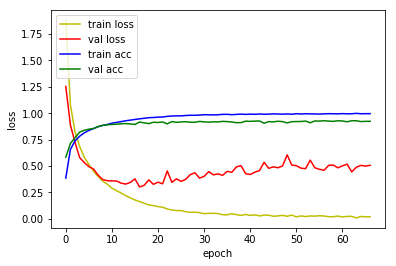

4815/4815 [==============================] - 1s 268us/sample - loss: 0.4302 - acc: 0.8787
Loss: 0.43015429144212636 Accuracy: 0.87871236

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.7823 - acc: 0.4206
Epoch 00001: val_loss improved from inf to 1.24133, saving model to model/checkpoint/1D_CNN_no_DO_5_conv_2_fcn_checkpoint/01-1.2413.hdf5
36805/36805 [==============================] - 17s 458us/sample - loss: 1.7822 - acc: 0.4206 - val_loss: 1.2413 - val_acc: 0.5870
Epoch 2/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.0366 - acc: 0.6698
Epoch 00002: val_loss improved from 1.24133 to 0.87159, saving model to model/checkpoint/1D_CNN_no_DO_5_conv_2_fcn_checkpoint/02-0.8716.hdf5
36805/36805 [==============================] - 11s 289us/sample - loss: 1.0359 - acc: 0.6701 - val_loss: 0.8716 - val_acc: 0.7188
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.7825 -

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9823
Epoch 00027: val_loss did not improve from 0.31283
36805/36805 [==============================] - 10s 284us/sample - loss: 0.0576 - acc: 0.9823 - val_loss: 0.4395 - val_acc: 0.9150
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0575 - acc: 0.9816
Epoch 00028: val_loss did not improve from 0.31283
36805/36805 [==============================] - 10s 283us/sample - loss: 0.0574 - acc: 0.9816 - val_loss: 0.3895 - val_acc: 0.9229
Epoch 29/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9852
Epoch 00029: val_loss did not improve from 0.31283
36805/36805 [==============================] - 10s 283us/sample - loss: 0.0476 - acc: 0.9852 - val_loss: 0.4236 - val_acc: 0.9171
Epoch 30/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0519 - acc: 0.9829
Epoch 00030: val_loss did not improve from 0.31283
36805/36805 [=====

Epoch 57/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0223 - acc: 0.9932
Epoch 00057: val_loss did not improve from 0.31283
36805/36805 [==============================] - 10s 283us/sample - loss: 0.0223 - acc: 0.9932 - val_loss: 0.5828 - val_acc: 0.9164
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0163 - acc: 0.9957
Epoch 00058: val_loss did not improve from 0.31283
36805/36805 [==============================] - 10s 283us/sample - loss: 0.0163 - acc: 0.9957 - val_loss: 0.4778 - val_acc: 0.9269
Epoch 59/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9937
Epoch 00059: val_loss did not improve from 0.31283
36805/36805 [==============================] - 10s 285us/sample - loss: 0.0215 - acc: 0.9937 - val_loss: 0.4809 - val_acc: 0.9229
Epoch 60/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9965
Epoch 00060: val_loss did not improve from 0.31283
36805/36805 [=====

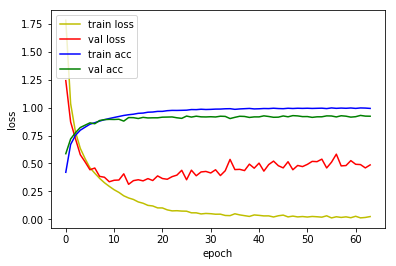

4815/4815 [==============================] - 1s 273us/sample - loss: 0.4229 - acc: 0.8706
Loss: 0.42294781881453214 Accuracy: 0.8706127



In [13]:
for i in range(1, 6):
    for j in range(1, 3):
        base = '1D_CNN_no_DO'
        model_name = base+'_{}_conv_{}_fcn'.format(i, j)
        model = build_cnn_no_DO(conv_num=i, fcn_num=j)
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
                      metrics=['accuracy'])
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])

        print()
        print(model_name, 'Model')
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()

        png_path = 'visualization/learning_curve/'
        filename = model_name+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)

        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()

        del(model)

In [15]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_no_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 6):
        for j in range(1, 3):
            model_name = base+'_{}_conv_{}_fcn'.format(i, j)
            print()
            print(model_name, 'Model')
            model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
            model_filename = model_path + sorted(os.listdir(model_path))[-1]

            model = load_model(model_filename)
            model.summary()

            [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
            print('Loss:', loss, 'Accuracy:', accuracy)

            del(model)

            log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_no_DO_1_conv_1_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 31952)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              32719872  
_________________________________________________________________
dense_38 (Dense)             (None, 16)                16400     
Total params: 32,736,480
Trainable params: 32,736,480
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 1s 294us/sample - loss: 1.2104 - acc: 0.6420
Loss: 1

4815/4815 [==============================] - 2s 332us/sample - loss: 0.5952 - acc: 0.8272
Loss: 0.5951518520759274 Accuracy: 0.8272067

1D_CNN_no_DO_4_conv_1_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 3970, 16)          3216      
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 993, 16)           0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 969, 32)           12832     
_________________________________________________________________
max_pooling1d_65 (MaxPooling (None, 243,

4815/4815 [==============================] - 2s 420us/sample - loss: 0.4229 - acc: 0.8706
Loss: 0.42294781881453214 Accuracy: 0.8706127
